# Лабораторная работа №5

## Линейные модели, SVM и деревья решений.

Цель лабораторной работы: изучение линейных моделей, SVM и деревьев решений.


In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

import math
from sklearn import utils
from typing import Dict, Tuple
%matplotlib inline 
sns.set(style="ticks")

## Выберите набор данных (датасет) для решения задачи классификации или регрессии.

Используем данные о баллах за экзамены.

In [34]:
# Будем использовать только обучающую выборку
data = pd.read_csv('datasets_74977_169835_StudentsPerformance.csv', sep=",")

In [35]:
# размер набора данных
data.shape

(1000, 8)

In [36]:
# типы колонок
data.dtypes

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

In [37]:
# проверим есть ли пропущенные значения
data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [38]:
# Первые 5 строк датасета
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [39]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 1000


In [40]:
#cумма баллов будет более полезным столбцом
data['sum'] = data['math score'] + data['reading score'] + data['writing score']
#удалим избыточные столбцы

del data['race/ethnicity']

In [41]:
#заменим строковые значения целевого признака на числовые
data.loc[data['test preparation course'] == 'none', 'test preparation course'] = 0
data.loc[data['test preparation course'] == 'completed', 'test preparation course'] = 1

data.loc[data['gender'] == 'female', 'gender'] = 0
data.loc[data['gender'] == 'male', 'gender'] = 1

data.loc[data['lunch'] ==  'free/reduced', 'lunch'] = 0
data.loc[data['lunch'] == 'standard', 'lunch'] = 1

data.loc[data['parental level of education'] ==  'some high school', 'parental level of education'] = 0
data.loc[data['parental level of education'] == 'some college', 'parental level of education'] = 0
data.loc[data['parental level of education'] == 'high school', 'parental level of education'] = 0
data.loc[data['parental level of education'] == "bachelor's degree",'parental level of education'] = 1
data.loc[data['parental level of education'] == "master's degree",'parental level of education'] = 1
data.loc[data['parental level of education'] == "associate's degree",'parental level of education'] = 1

In [42]:
data.head()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,sum
0,0,1,1,0,72,72,74,218
1,0,0,1,1,69,90,88,247
2,0,1,1,0,90,95,93,278
3,1,1,0,0,47,57,44,148
4,1,0,1,0,76,78,75,229


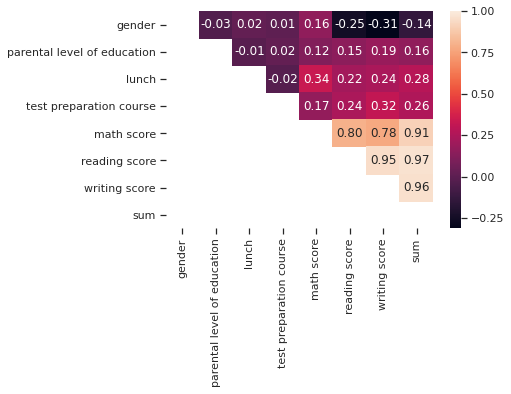

In [43]:
# Треугольный вариант матрицы
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.tril_indices_from(mask)] = True
sns.heatmap(data.corr(method='spearman'), mask=mask, annot=True, fmt='.2f')

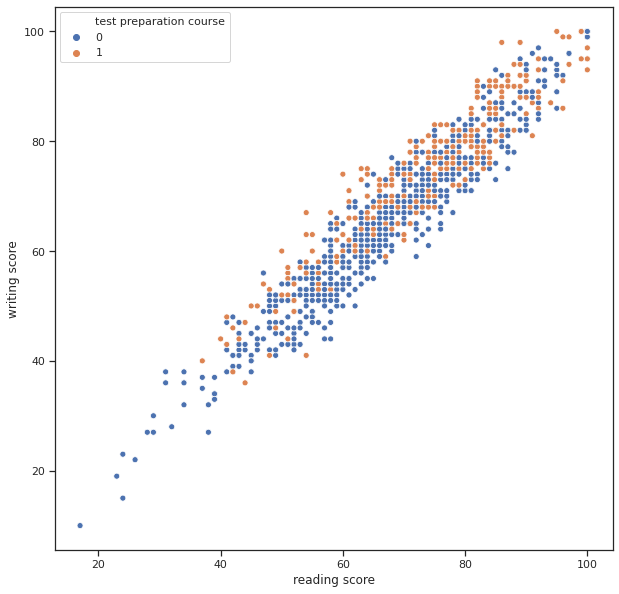

In [45]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.scatterplot(ax=ax, x='reading score', y='writing score', data=data, hue='test preparation course')

In [46]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-x_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [47]:
x_array = data['reading score'].values
y_array = data['writing score'].values

In [48]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(-0.6675536409329368, 0.9935311142409596)

In [49]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [50]:
y_array_regr = y_regr(x_array, b0, b1)

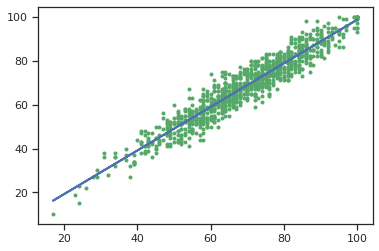

In [52]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.show()

In [67]:
iris = data
iris_X = arr[:, [1,2]]
iris_y = arr2

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(iris_X, iris_y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = iris_X[:, 0], iris_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=iris_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('math score')
    ax.set_ylabel('sum')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

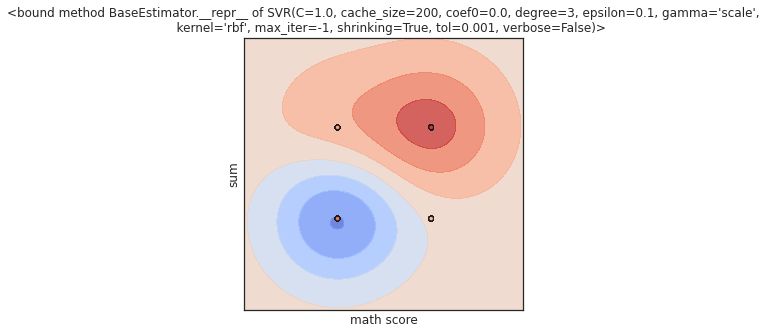

In [68]:
plot_cl(SVR())

In [71]:
def plot_tree_classification(title_param, ds):
    """
    Построение деревьев и вывод графиков для заданного датасета
    """
    
    n_classes = 4
    plot_colors = "ryb"
    plot_step = 0.02
    arr=data.to_numpy()
    for pairidx, pair in enumerate([[1, 2], [1, 6], [2, 6]]):
        # We only take the two corresponding features
        X = arr[:, pair]
        y = arr[:, [7]]

        # Train
        clf = DecisionTreeRegressor(random_state=0).fit(X, y)

        plt.title(title_param)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

        plt.xlabel(data.columns[pair[0]])
        plt.ylabel(data.columns[pair[1]])

        # Plot the training points
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=color, label=data.columns[i],
                        cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

        plt.show() 

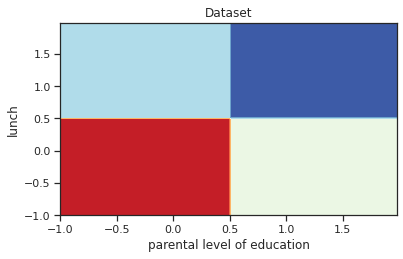

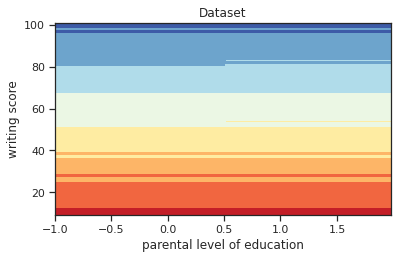

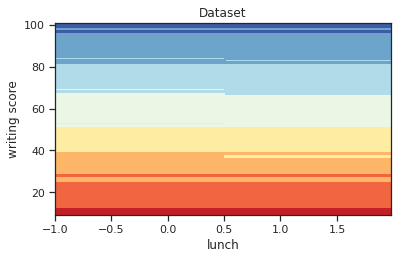

In [72]:
plot_tree_classification('Dataset', data)